## Self-Supervised Pre-training [30 marks]

### What is rotation classification task?
One important self-training task is the task of rotation classification. Here given a set of unlabeled images, we randomly rotate it to either of the following angles {0, 90, 180, 270} degrees and train a image rotation classifier which predicts by what angle the initial image has been rotated to generate the current image. The problem is set up as a classification problem since we only rotate our images by a fixed set of angles as mentioned before and the corresponding ground truth labels being {0, 1, 2, 3}.

<center>
<img src="./fig/Self-training-rot.png" width="524" height="300">
</center>

Once the self-training based pretraining is done, we strip away the final classification layer(which is a linear layer) and add Convolutional or linear layers as per the downstream task's requirement.


### Details of this problem statement.

1. Take the CIFAR-10 dataset, each class has 5000 samples and there are 10 classes.
Split the dataset in 2 parts (A) 40000 and (B) 10000 each with equal number of samples per class in each split.
2. Discard the labels of the samples in the first set.
3. Take a resnet-18 (initialised) and strip the imagenet classification layer with a 4 way classification layer.
4. Train this network on the self-training task of classifiying the rotation of the image.
5. Once this self-supervised pretraining is done, strip the classification layer and add a classification layer for CIFAR-10 classification this is finetuned on the set B for the task of image classification.
6. Log the loss(cross entropy) and accuracies for both the pre-training task and classfication task.

You are free tou use ML API of your choice. Your work will be checked for plagiarism!!

### Citations and helpful references 
[1]. https://www.youtube.com/watch?v=8L10w1KoOU8&t=694s <br>
[2]. https://openaccess.thecvf.com/content_CVPR_2019/papers/Feng_Self-Supervised_Representation_Learning_by_Rotation_Feature_Decoupling_CVPR_2019_paper.pdf

In [66]:
import torchvision.datasets as dataset
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import random
from torchvision.transforms import v2
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt 

In [67]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_item = self.data[index]
        label_item = self.labels[index]

        return data_item, label_item


In [68]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

    
transform_ = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])
CIFAR=dataset.CIFAR10(root="/root/DLVA Assig-2/Assignment2/Assignment2/dataset", train=True, download=True,transform=transform_)

A_idx = []
B_idx = []

# Counters to keep track of the number of samples per class in each split
A = {i: 0 for i in range(10)}
B = {i: 0 for i in range(10)}
part_A=[]

for idx, (data, target) in enumerate(CIFAR):
    # Determine which part to assign the sample to
    if B[target] < 1000:
        B_idx.append(idx)
        B[target] += 1
        
    else:
        A_idx.append(idx)
        A[target] += 1
        part_A.append(data)

    # Break the loop once we have enough samples for both parts
    if sum(A.values()) >= 40000 and sum(B.values()) >= 10000:
        break


part_B = torch.utils.data.Subset(CIFAR, B_idx)

# Create DataLoaders for parts A and B
dataloader_A = torch.utils.data.DataLoader(part_A, batch_size=40000, shuffle=False)

for dat in dataloader_A:
        idx=0
        rot=[3]*len(dat)
        rotated=[]
        for image in dat:
        # Applying the rotation
        
            angle=random.choice([0, 90, 180, 270])
            rotate_transform = transforms.Compose([
                            transforms.ToPILImage(),  
                            v2.RandomRotation(degrees=(angle,angle)),
                            transforms.ToTensor()
                            ])
            if angle==0:
                rot[idx]=0
                idx+=1
            elif angle==90:
                rot[idx]=1
                idx+=1
            elif angle==180:
                rot[idx]=2
                idx+=1
            elif angle==270:
                rot[idx]=3
                idx+=1

        # Applying the rotation
            rotated.append(rotate_transform(image).to(device))
        rotated_tensor = torch.stack(rotated).to(device)



rots=torch.tensor(rot)

part_A_rotated_dataset = MyDataset(rotated_tensor, rots)
dataloader_A_final=torch.utils.data.DataLoader(part_A_rotated_dataset, batch_size=64, shuffle=True)
dataloader_B = torch.utils.data.DataLoader(part_B, batch_size=64, shuffle=True)


GPU is available.
Files already downloaded and verified


Original Image


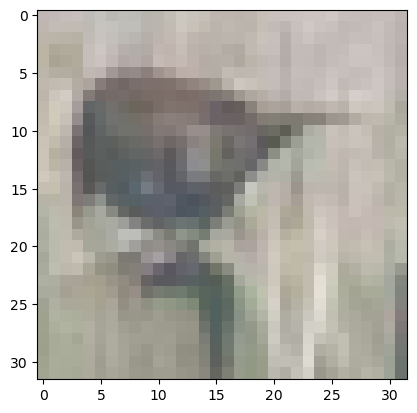

In [69]:
print("Original Image")
im=part_A[0].numpy().transpose(1,2,0)
plt.imshow(im)


Randomly Rotated Image


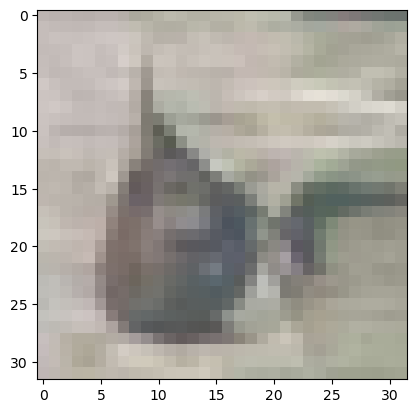

In [70]:
print("Randomly Rotated Image")
plt.imshow(rotated_tensor[0].cpu().numpy().transpose(1,2,0))

In [71]:
resnet_model = models.resnet18(pretrained=True).to(device)
resnet_model = torch.nn.Sequential(*(list(resnet_model.children())[:-1])).to(device)
print(resnet_model)
improved_model = nn.Sequential(
    resnet_model,
    nn.Flatten(),
    nn.Linear(512, 4)
).to(device)
print(improved_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

c:\Users\akshe\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\akshe\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Training Loss: 680.7300088405609, Training Accuracy= 50.7825 
Epoch 2/50, Training Loss: 514.3588292002678, Training Accuracy= 65.51249999999999 
Epoch 3/50, Training Loss: 433.15021815896034, Training Accuracy= 71.7925 
Epoch 4/50, Training Loss: 371.24418687820435, Training Accuracy= 76.17 
Epoch 5/50, Training Loss: 316.55415320396423, Training Accuracy= 80.1125 
Epoch 6/50, Training Loss: 267.55220860242844, Training Accuracy= 83.4025 
Epoch 7/50, Training Loss: 221.1531130373478, Training Accuracy= 86.44 
Epoch 8/50, Training Loss: 181.92693666368723, Training Accuracy= 89.1175 
Epoch 9/50, Training Loss: 152.768743917346, Training Accuracy= 90.99000000000001 
Epoch 10/50, Training Loss: 125.33014465868473, Training Accuracy= 92.63749999999999 
Epoch 11/50, Training Loss: 104.47431114688516, Training Accuracy= 93.8675 
Epoch 12/50, Training Loss: 89.37596495822072, Training Accuracy= 94.80499999999999 
Epoch 13/50, Training Loss: 75.38422455452383, Training Accuracy= 9

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


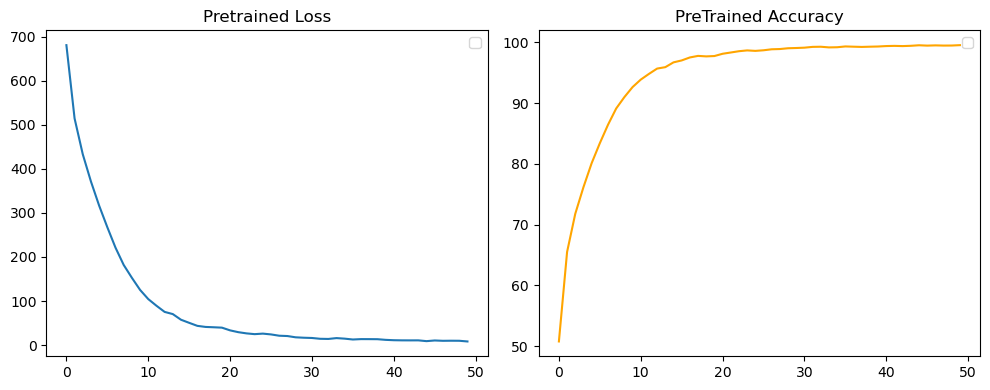

In [72]:
#Training for self-supervision using dataset A

criterion = nn.CrossEntropyLoss(weight=torch.ones(4)).to(device)
optimizer = optim.SGD(improved_model.parameters(), lr=0.0005, momentum=0.9)

# Training loop
epochs = 50 # Set the number of training epochs

loss_couter=[]
acc_counter=[]
for epoch in range(epochs):
    epoch_loss=0.0
    correct_predictions=0
    for dat,rot_ in dataloader_A_final:
        dat=dat.to(device)
        rot_=rot_.to(device)
        
        outputs = improved_model(dat).to(device)
        # Compute loss
      
        out=[]*outputs.shape[0]
        for ih in range(outputs.shape[0]):
            out.append(torch.argmax(outputs[ih][:]).to(device))

        loss = criterion(outputs, rot_)
       
        #print(out == rot_).sum().item()
        #print(out)
        out_tensor=torch.round(torch.tensor(out))
        out_int=out_tensor.to(torch.int64)
        correct_predictions +=(out_int.to(device)== rot_).sum().item()
        

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
        
    loss_couter.append(epoch_loss)
    acc_counter.append(correct_predictions/40000*100)
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {epoch_loss}, Training Accuracy= {correct_predictions/40000*100} ")

torch.save(improved_model, 'my_pretrained_model.pt')

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot data on the first subplot
axs[0].plot(loss_couter)
axs[0].set_title('Pretrained Loss')
axs[0].legend()

# Plot data on the second subplot
axs[1].plot(acc_counter, color='orange')
axs[1].set_title('PreTrained Accuracy')
axs[1].legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()
        

In [73]:

pretrained_model = torch.load('my_pretrained_model.pt')
pretrained_model = torch.nn.Sequential(*(list(pretrained_model.children())[:-1])).to(device)
print(pretrained_model)
finetune_model = nn.Sequential(
    pretrained_model,
    nn.Flatten(),
    nn.Linear(512, 10)
).to(device)
print(finetune_model)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

Epoch 1/25, Training Loss: 223.09001338481903, Training Accuracy= 13.442499999999999
Epoch 2/25, Training Loss: 142.32328081130981, Training Accuracy= 17.595
Epoch 3/25, Training Loss: 150.19186037778854, Training Accuracy= 17.299999999999997
Epoch 4/25, Training Loss: 101.16599136590958, Training Accuracy= 19.6575
Epoch 5/25, Training Loss: 70.99478466808796, Training Accuracy= 21.2625
Epoch 6/25, Training Loss: 51.2961840480566, Training Accuracy= 22.2825
Epoch 7/25, Training Loss: 49.9892592728138, Training Accuracy= 22.465
Epoch 8/25, Training Loss: 37.28276675194502, Training Accuracy= 22.997500000000002
Epoch 9/25, Training Loss: 32.01675923354924, Training Accuracy= 23.24
Epoch 10/25, Training Loss: 20.772835716605186, Training Accuracy= 24.002499999999998
Epoch 11/25, Training Loss: 13.902298213448375, Training Accuracy= 24.2775
Epoch 12/25, Training Loss: 4.723486409289762, Training Accuracy= 24.779999999999998
Epoch 13/25, Training Loss: 4.876633793232031, Training Accuracy= 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


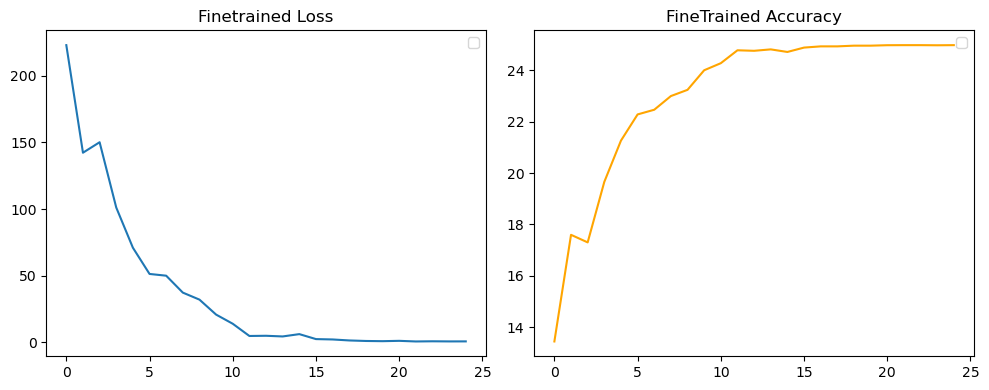

In [74]:
epochs = 25 # Set the number of training epoch
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(finetune_model.parameters(), lr=0.01, momentum=0.9)

loss_couter=[]
acc_counter=[]
for epoch in range(epochs):
    if epoch == 10:
        new_lr = 0.005
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr
    elif epoch==15:
        new_lr = 0.001
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr
    elif epoch==20:
        new_lr = 0.0005
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr


    epoch_loss=0.0
    correct_predictions=0
    for dat,lab in dataloader_B:
        dat=dat.to(device)
        lab=lab.to(device)
        outputs = finetune_model(dat).to(device)

        loss = criterion(outputs, lab)
        out=[]*outputs.shape[0]
        for ih in range(outputs.shape[0]):
            out.append(torch.argmax(outputs[ih][:]))
       
        out_int=torch.tensor(out).to(torch.int64)
        correct_predictions +=(out_int.to(device)== lab).sum().item()
    

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
        
    loss_couter.append(epoch_loss)
    acc_counter.append(correct_predictions/40000*100)
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {epoch_loss}, Training Accuracy= {correct_predictions/40000*100}")

torch.save(finetune_model, 'my_finetune_model.pt')

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot data on the first subplot
axs[0].plot(loss_couter)
axs[0].set_title('Finetrained Loss')
axs[0].legend()

# Plot data on the second subplot
axs[1].plot(acc_counter, color='orange')
axs[1].set_title('FineTrained Accuracy')
axs[1].legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()
        

    